In [115]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.integrate as intgr
from numpy import sqrt
import numpy.linalg as lin
%matplotlib inline

import pdb
Macs_income = np.loadtxt('/Users/donghaiy/Desktop/Macs_30100/persp-model_W18/ProblemSets/PS2/incomes.txt')

### (a) plot the histogram, bin = 30

<IPython.core.display.Javascript object>


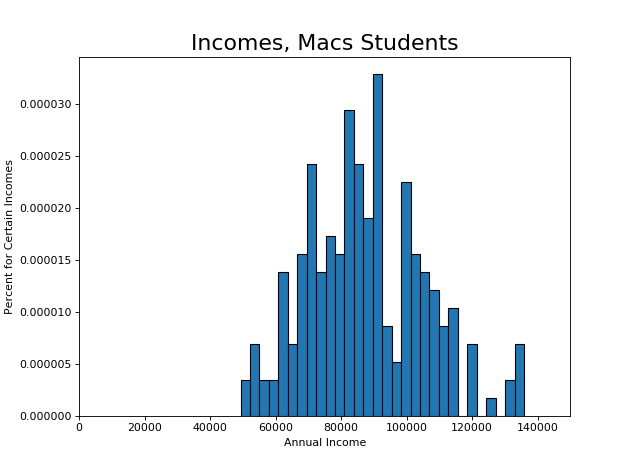

(0, 150000)

In [116]:
import matplotlib.pyplot as plt
# This next command is specifically for Jupyter Notebook
%matplotlib notebook
fig2 = plt.figure(figsize=(8,6))
count, bins, ignored = plt.hist(Macs_income, 30, edgecolor='black', normed=True)
plt.title('Incomes, Macs Students', fontsize=20)
plt.xlabel('Annual Income')
plt.ylabel('Percent for Certain Incomes')
plt.xlim([0, 150000])  # This gives the xmin and xmax to be plotted"
# Don't set this figure until have played with the figure below

In [40]:
# get lognorm in the trucnorm function
def trunc_pdf(xvals, mu, sigma, cutoff='None', cdf=0):
    if cdf:
        if cutoff == 'None':
            vals = sts.lognorm.cdf(xvals, s=sigma, scale=np.exp(mu))
        else:
            prob_notcut = sts.lognorm.cdf(cutoff, s=sigma, scale=np.exp(mu)) - sts.lognorm.cdf(0, s=sigma, scale=np.exp(mu))
            vals = sts.lognorm.cdf(xvals, s=sigma, scale=np.exp(mu)) / prob_notcut
    else:
        if cutoff == 'None':
            vals = sts.lognorm.pdf(xvals, s=sigma, scale=np.exp(mu))
        else:
            prob_notcut = sts.lognorm.cdf(cutoff, s=sigma, scale=np.exp(mu)) - sts.lognorm.cdf(0, s=sigma, scale=np.exp(mu))
            vals = sts.lognorm.pdf(xvals, s=sigma, scale=np.exp(mu)) / prob_notcut
    return vals

###### Now let's define a criterion function that takes as inputs the parameters and the estimator for the weighting matrix $\hat{W}$.

In [117]:
def moments_model(mu, sigma, cutoff):
    
    xfx = lambda x: x * trunc_pdf(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, 0, cutoff)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_pdf(x, mu, sigma, cutoff)
    (sigma_model, s_m_err) = sqrt(intgr.quad(x2fx, 0, cutoff))
    
    return mean_model, sigma_model

In [118]:
def moments_data(xvals):

    return xvals.mean(), xvals.std()

In [119]:
def err_1(xvals, mu, sigma, cutoff):

    mean_model, sigma_model = moments_model(mu, sigma, cutoff)
    mean_data, sigma_data = moments_data(xvals)
    model = np.array([[mean_model], [sigma_model]])
    data = np.array([[mean_data], [sigma_data]])
    err = (model - data) / data
    
    return err

In [120]:

def crit_1(params, *args):

    mu, sigma = params
    xvals, cutoff, W = args
    err_v = err_1(xvals, mu, sigma, cutoff)
    crit_val = err_v.T @ W @ err_v
    
    return crit_val

### (B) GMM estimation

In [121]:
mu_1, sigma_1 = 11.3, 0.21
params_1 = np.array([mu_1, sigma_1])
W_hat_1 = np.eye(2)
args_1 = (Macs_income, 150000, W_hat_1)
results_1A = opt.minimize(crit_1, params_1, args=(args_1),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

In [122]:
def rr(*args):

    return list(np.round(x,4) for x in args)

In [123]:
mu_GMM1, sig_GMM1 = results_1A.x
print('mu_GMM =', *rr(mu_GMM1), ' sig_GMM =', *rr(sig_GMM1))
print('Value of GMM criterion:', *crit_1(results_1A.x, *args_1)[0])

print('\naverage income(data) =', 
      *rr(moments_data(Macs_income)[0]), 
      '\nstandard deviation of income(data) =', 
      *rr(moments_data(Macs_income)[1]))
model = moments_model(mu_GMM1, sig_GMM1, 150000)
print('\naverage income(model) =', *rr(model[0]), 
      '\nstandard deviation of income(model) =', 
      *rr(model[1]))

mu_GMM = 11.3618  sig_GMM = 0.209
Value of GMM criterion: 5.75472828466e-14

average income(data) = 87588.9308 
standard deviation of income(data) = 18035.9068

average income(model) = 87588.926 
standard deviation of income(model) = 18035.9026


#### So we can see that the two moments are close

<IPython.core.display.Javascript object>


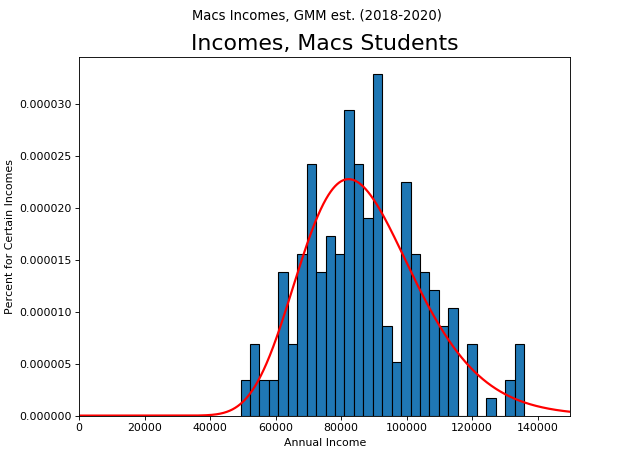

In [124]:
fig2 = plt.figure(figsize=(8,6))

count, bins, ignored = plt.hist(Macs_income, 30, edgecolor='black', normed=True)
plt.title('Incomes, Macs Students', fontsize=20)
plt.xlabel('Annual Income')
plt.ylabel('Percent for Certain Incomes')
plt.suptitle('Macs Incomes, GMM est. (2018-2020)')
plt.xlim([0, 150000])
dist_pts = np.linspace(0, 150000, 150000)
plt.plot(dist_pts, trunc_pdf(dist_pts, mu_GMM1, sig_GMM1, cutoff = 150000),
     linewidth=2, color='r', 
         label=f'GMM parameters: $\mu$={round(mu_GMM1,2)}, $\sigma$ = {round(sig_GMM1,2)}')

### (C) Two-step GMM estimator, by using your estimates¶

In [125]:
err1 = err_1(Macs_income, mu_GMM1, sig_GMM1, cutoff=150000)
Omega_1 = err1 @ err1.T / Macs_income.shape[0]
W_hat_1B = lin.pinv(Omega_1) # Omega_1 is a sigular matrix
args_1B = (Macs_income, 150000, W_hat_1B)
results_1B = opt.minimize(crit_1, results_1A.x, args=(args_1B),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results_1B.x

/Users/donghaiy/Desktop/Macs_30100/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/donghaiy/Desktop/Macs_30100/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/Users/donghaiy/Desktop/Macs_30100/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/donghaiy/Desktop/Macs_30100/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [126]:
print('mu_GMM =', *rr(mu_GMM2), ' sig_GMM =', *rr(sig_GMM2))
print('Value of GMM criterion:', *crit_1(results_1B.x, *args_1B)[0])

print('\naverage income(data) =', *rr(moments_data(Macs_income)[0]), 
      '\nstandard deviation(data) =', *rr(moments_data(Macs_income)[1]))
model1 = moments_model(mu_GMM1, sig_GMM1, 150000)
model2 = moments_model(mu_GMM2, sig_GMM2, 150000)
print('\naverage income(model: one-step) =', *rr(model1[0]), 
      '\nstandard deviation(model: one-step) =', *rr(model1[1]))
print('\naverage income(model: two-step) =', *rr(model2[0]), 
      '\nstandard deviation(model: two-step) =', *rr(model2[1]))

mu_GMM = 11.3618  sig_GMM = 0.209
Value of GMM criterion: 0.195110399745

average income(data) = 87588.9308 
standard deviation(data) = 18035.9068

average income(model: one-step) = 87588.926 
standard deviation(model: one-step) = 18035.9026

average income(model: two-step) = 87588.9274 
standard deviation(model: two-step) = 18035.9068


### Still, the two moments of data and model are close

<IPython.core.display.Javascript object>


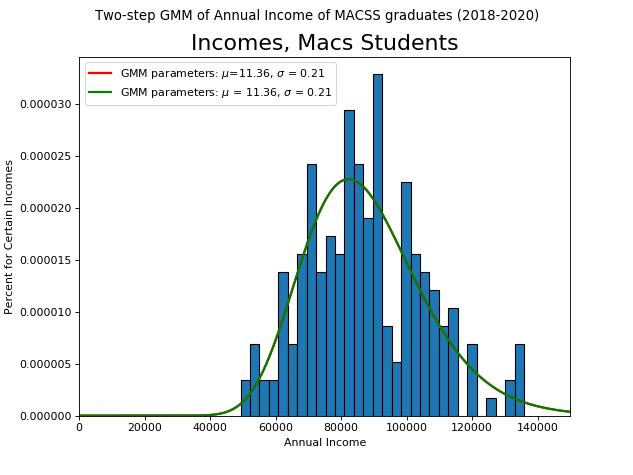

In [127]:
fig3 = plt.figure(figsize=(8,6))

count, bins, ignored = plt.hist(Macs_income, 30, edgecolor='black', normed=True)

plt.suptitle('Two-step GMM of Annual Income of MACSS graduates (2018-2020)')
plt.title('Incomes, Macs Students', fontsize=20)
plt.xlabel('Annual Income')
plt.ylabel('Percent for Certain Incomes')
plt.xlim([0, 150000])
dist_pts = np.linspace(0, 150000, 150000)
plt.plot(dist_pts, trunc_pdf(dist_pts, mu_GMM1, sig_GMM1, cutoff = 150000),
     linewidth=2, color='r', label=f'GMM parameters: $\mu$={round(mu_GMM1,2)}, $\sigma$ = {round(sig_GMM1,2)}')
plt.plot(dist_pts, trunc_pdf(dist_pts, mu_GMM2, sig_GMM2, cutoff = 150000),
     linewidth=2, color='g', label=f'GMM parameters: $\mu$ = {round(mu_GMM2,2)}, $\sigma$ = {round(sig_GMM2,2)}')
plt.legend(loc='best')

### (D) Estimate the lognormal PDF to fit the data by GMM using different moments.

In [128]:
def permoments_data(xvals):

    per1 = len(xvals[xvals < 75000]) / len(xvals)
    per3 = len(xvals[xvals > 100000]) / len(xvals)
    per2 = 1 - per1 - per3
    return per1, per2, per3

In [129]:
def permoments_model(mu, sigma, cutoff):

    per1 = trunc_pdf(75000, mu, sigma, cutoff, cdf=1)
    per2 = trunc_pdf(100000, mu, sigma, cutoff, cdf=1) - per1
    per3 = 1 - per2 - per1
    return per1, per2, per3

In [130]:
def crit_2(params, *args):

    mu, sigma = params
    xvals, cutoff, W = args
    err_v = err_2(xvals, mu, sigma, cutoff)
    crit_val = err_v.T @ W @ err_v
    
    return crit_val

In [131]:

def err_2(xvals, mu, sigma, cutoff):

    per1_model, per2_model, per3_model = permoments_model(mu, sigma, cutoff)
    per1_data, per2_data, per3_data = permoments_data(xvals)
    model = np.array([[per1_model], [per2_model], [per3_model]])
    data = np.array([[per1_data], [per2_data], [per3_data]])
    err = (model - data) / data
    
    return err

In [132]:
mu_2, sigma_2 = 11.3, 0.212
params_2 = np.array([mu_2, sigma_2])
W_hat_2 = np.eye(3)
args_2 = (Macs_income, 'None', W_hat_2)
results_2 = opt.minimize(crit_2, params_2, args=(args_2),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

In [133]:
results_2

      fun: array([[  4.33150758e-14]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -9.37240425e-07,  -1.91709336e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 6
   status: 0
  success: True
        x: array([ 11.36734891,   0.2262805 ])

In [134]:
mu_GMM3, sig_GMM3 = results_2.x
print('mu_GMM =', *rr(mu_GMM3), ' sig_GMM =', *rr(sig_GMM3))
print('Value of GMM criterion:', (*crit_2(results_2.x, *args_2)[0]))
print('\nThree moments(data):', *rr(*permoments_data(Macs_income)))
model3 = permoments_model(mu_GMM3, sig_GMM3, 'None')
print('\nThree moments(model):', *rr(*model3))

mu_GMM = 11.3673  sig_GMM = 0.2263
Value of GMM criterion: 4.33150758019e-14

Three moments(data): 0.265 0.475 0.26

Three moments(model): 0.265 0.475 0.26


<IPython.core.display.Javascript object>


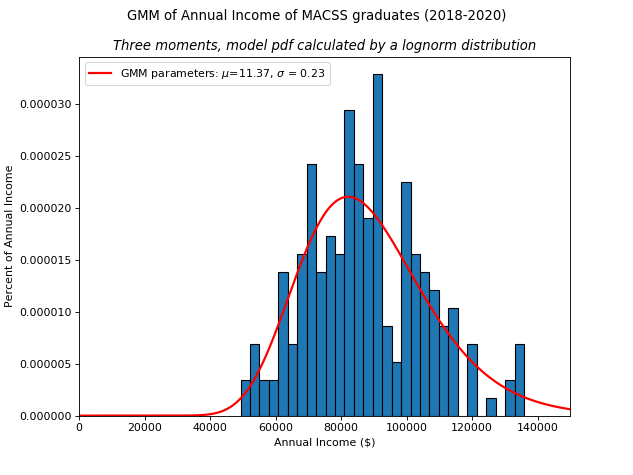

In [135]:
fig4 = plt.figure(figsize=(8,6))

count, bins, ignored = plt.hist(Macs_income, 30, edgecolor='black', normed=True)

plt.suptitle('GMM of Annual Income of MACSS graduates (2018-2020)')
plt.title('Three moments, model pdf calculated by a lognorm distribution', style = 'italic')
plt.xlabel(r'Annual Income (\$)')
plt.ylabel(r'Percent of Annual Income')
plt.xlim([0, 150000])
dist_pts = np.linspace(0, 150000, 150000)
plt.plot(dist_pts, trunc_pdf(dist_pts, mu_GMM3, sig_GMM3, cutoff = 150000),
     linewidth=2, color='r', label=f'GMM parameters: $\mu$={round(mu_GMM3,2)}, $\sigma$ = {round(sig_GMM3,2)}')
plt.legend(loc='best')

### (e) Perform the two-step GMM estimator, using your estimates from part (d)¶

In [136]:
err3 = err_2(Macs_income, mu_GMM3, sig_GMM3, cutoff=150000)
Omega_2 = err3 @ err3.T / Macs_income.shape[0]
W_hat_2B = lin.pinv(Omega_2) # Omega_2 is a sigular matrix

args_2B = (Macs_income, 150000, W_hat_2B)
results_2B = opt.minimize(crit_2, results_2.x, args=(args_2B),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM4, sig_GMM4 = results_2B.x

In [137]:
params_2B = np.array([mu_GMM4, sig_GMM4])

print('mu_GMM =', *rr(mu_GMM4), ' sig_GMM =', *rr(sig_GMM4))
print('Value of GMM criterion 4:', crit_2(params_2B, *args_2B)[0][0])
print('\nThe three moments(data):', *rr(permoments_data(Macs_income)))
print('\nThe three moments(model:one step):', *rr(permoments_model(mu_GMM3, sig_GMM3, 150000)))
print('\nThe three moments(model:two step):', *rr(permoments_model(mu_GMM4, sig_GMM4, 150000)))

mu_GMM = 11.3705  sig_GMM = 0.2276
Value of GMM criterion 4: 2.15505709944e-10

The three moments(data): [ 0.265  0.475  0.26 ]

The three moments(model:one step): [ 0.267   0.4786  0.2545]

The three moments(model:two step): [ 0.2637  0.4764  0.2598]


<IPython.core.display.Javascript object>


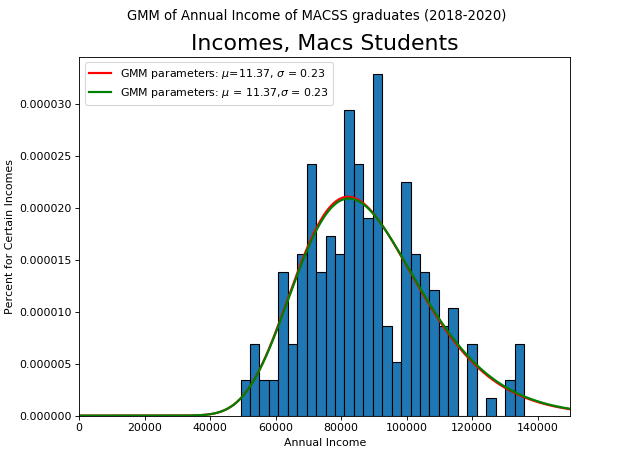

In [138]:
ig4 = plt.figure(figsize=(8,6))

count, bins, ignored = plt.hist(Macs_income, 30, edgecolor='black', normed=True)

plt.suptitle('GMM of Annual Income of MACSS graduates (2018-2020)')
plt.title('Incomes, Macs Students', fontsize=20)
plt.xlabel('Annual Income')
plt.ylabel('Percent for Certain Incomes')
plt.xlim([0, 150000])
dist_pts = np.linspace(0, 150000, 150000)
plt.plot(dist_pts, trunc_pdf(dist_pts, mu_GMM3, sig_GMM3, cutoff = 150000),
     linewidth=2, color='r', 
         label=f'GMM parameters: $\mu$={round(mu_GMM3,2)}, $\sigma$ = {round(sig_GMM3,2)}')
plt.legend(loc='best')
plt.plot(dist_pts, trunc_pdf(dist_pts, mu_GMM4, sig_GMM4, cutoff = 150000),
     linewidth=2, color='g', 
         label=f'GMM parameters: $\mu$ = {round(mu_GMM4,2)},$\sigma$ = {round(sig_GMM4,2)}')
plt.legend(loc='best')

### the model in (d) yields the smallest criterion value, so model in (d) should fits the data best.
But since these models yield very close values, choosing differenet model would not make a big difference. In other cases, it is important to compare the differences between the criterion values yielded to decide which model to be used. 



### Problem 2
Estimate the parameters of the model ($\beta0$; $\beta1$; $\beta2$; $\beta3$) by GMM by solving the minimization problem of the GMM criterion function.

In [139]:
#Load Data
sick = np.loadtxt('sick.txt', skiprows=1, delimiter=',')

In [140]:
def err_3(xvals, b0, b1, b2, b3):

    moms_data = sick[:,0]
    moms_model = b0 + b1*sick[:,1] + b2*sick[:,2] + b3*sick[:,3]
    err = moms_data - moms_model 
    return err

In [141]:

def crit_3(params, *args):

    b0, b1, b2, b3 = params
    xvals, W = args
    err = err_3(xvals, *params)
    crit_val = err.T @ W @ err
    
    return crit_val

In [142]:
params_3 = np.array([0, 0, 0, 0]) #Set all parameters to 0
W_hat_3 = np.eye(200)
args_3 = (sick, W_hat_3)

#estimate parameters
results_3 = opt.minimize(crit_3, params_3, args=(args_3), method = 'L-BFGS-B')
b0_GMM, b1_GMM, b2_GMM, b3_GMM = results_3.x

In [143]:
crit_sick = crit_3(results_3.x, *args_3)
print('b0_GMM=', round(b0_GMM,4), ' \nb1_GMM=', round(b1_GMM,4), '\nb2_GMM=', round(b2_GMM,4), ' \nb3_GMM=', round(b3_GMM,4))
print('Value of GMM criterion:', round(crit_sick,4))

b0_GMM= 0.2516  
b1_GMM= 0.0129 
b2_GMM= 0.4005  
b3_GMM= -0.01
Value of GMM criterion: 0.0018
